In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torchmodel import UNet
from root_dataset import Train_dataset, Test_dataset
import albumentations as albu
import segmentation_models_pytorch as smp
import random
import numpy as np
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

/opt/homebrew/Caskroom/miniconda/base/envs/ptch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
height = 1024

In [4]:
def get_train_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        albu.GridDistortion(p=0.5),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.5),
        albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
        albu.GaussNoise(),
        albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
        #albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [5]:
def get_val_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        # albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [6]:
train_aug = get_train_augmentation(height)
val_aug = get_val_augmentation(height)

In [7]:
train = Train_dataset(height,train_aug,'crosval/train','castom-masks/masks_machine',device)
val = Train_dataset(height,val_aug,'crosval/val','castom-masks/masks_machine',device)

['AAE_0196.png', 'AAE_0182.png', 'AAE_0021.png', 'AAE_0236.png', 'AAE_0140.png', 'AAE_0154.png', 'AAE_0181.png', 'AAE_0156.png', 'AAE_0036.png', 'AAE_0022.png', 'AAE_0209.png', 'AAE_0180.png', 'AAE_0184.png', 'AAE_0190.png', 'AAE_0147.png', 'AAE_0027.png', 'AAE_0218.png', 'AAE_0146.png', 'AAE_0185.png', 'AAE_0193.png', 'AAE_0150.png', 'AAE_0226.png', 'AAE_0233.png', 'AAE_0019.png', 'AAE_0025.png', 'AAE_0179.png', 'AAE_0145.png', 'AAE_0192.png', 'AAE_0136.png', 'AAE_0057.png', 'AAE_0080.png', 'AAE_0041.png', 'AAE_0040.png', 'AAE_0068.png', 'AAE_0083.png', 'AAE_0097.png', 'AAE_0124.png', 'AAE_0087.png', 'AAE_0045.png', 'AAE_0119.png', 'AAE_0125.png', 'AAE_0127.png', 'AAE_0047.png', 'AAE_0085.png', 'AAE_0117.png', 'AAE_0063.png', 'AAE_0076.png', 'AAE_0062.png', 'AAE_0089.png', 'AAE_0116.png', 'AAE_0100.png', 'AAE_0114.png', 'AAE_0048.png', 'AAE_0101.png', 'AAE_0071.png', 'AAE_0058.png', 'AAE_0070.png', 'AAE_0073.png', 'AAE_0098.png', 'AAE_0107.png', 'AAE_0174.png', 'AAE_0028.png', 'AAE_00

<Figure size 640x480 with 0 Axes>

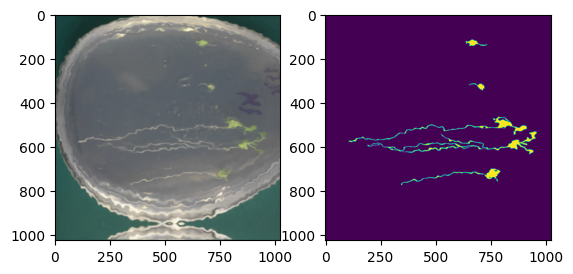

In [8]:
plt.figure()
f, axarr = plt.subplots(1,2) 
image,mask = train.__getitem__(0)
axarr[0].imshow(image.permute(1,2,0).cpu())
axarr[1].imshow(mask.permute(1,2,0).cpu())

In [9]:
model = UNet(3,1)

In [10]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False)

In [11]:
focal_loss = smp.losses.FocalLoss('binary')
iou_loss = smp.losses.JaccardLoss('binary')
dice_loss = smp.losses.DiceLoss('binary')
bce_loss = smp.losses.SoftBCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),0.001,amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,verbose=True)

In [12]:
def loss_f(outputs, targets):
    return focal_loss(outputs, targets) * 0.2 + iou_loss(outputs, targets) * 0.2 + dice_loss(outputs, targets) * 0.4 + bce_loss(outputs,targets) * 0.2

In [13]:
def metric(outputs, targets):
    return 1 - dice_loss(outputs, targets)

In [14]:
epochs = 100
patience = 20
model_path =  'best-model.pt'

In [15]:
model.to(device)
best_loss = 100
counter = 0
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_f(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss = 0.0

    model.eval()
    for inputs, targets in tqdm(val_loader):
        model.eval()
        outputs = model(inputs)
            
            # Calculate loss
        loss = loss_f(outputs, targets)
        val_loss += loss.item()

    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    improve = False

    if val_loss < best_loss: 
        best_loss = val_loss
        improve = True
        print('model saved')
        torch.save(model,model_path)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Dice: {metric(outputs, targets):.4f} | Val Dice: {metric(outputs, targets):.4f}")

    if not improve:
        counter += 1
        if counter > patience:
            print('early stop')
            break
    else:
        counter = 0
        

  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([10, 32, 512, 512])
torch.Size([10, 64, 256, 256])
torch.Size([10, 128, 128, 128])
torch.Size([10, 256, 64, 64])
torch.Size([10, 512, 32, 32])
torch.Size([10, 256, 64, 64])
torch.Size([10, 128, 128, 128])
torch.Size([10, 64, 256, 256])


 12%|█▎        | 1/8 [01:14<08:38, 74.07s/it]

torch.Size([10, 32, 512, 512])
torch.Size([10, 64, 256, 256])
torch.Size([10, 128, 128, 128])
torch.Size([10, 256, 64, 64])
torch.Size([10, 512, 32, 32])
torch.Size([10, 256, 64, 64])
torch.Size([10, 128, 128, 128])
torch.Size([10, 64, 256, 256])


 25%|██▌       | 2/8 [02:34<07:47, 77.90s/it]

torch.Size([10, 32, 512, 512])
torch.Size([10, 64, 256, 256])
torch.Size([10, 128, 128, 128])
torch.Size([10, 256, 64, 64])
torch.Size([10, 512, 32, 32])
torch.Size([10, 256, 64, 64])
torch.Size([10, 128, 128, 128])
torch.Size([10, 64, 256, 256])


 38%|███▊      | 3/8 [03:48<06:20, 76.14s/it]

torch.Size([10, 32, 512, 512])
torch.Size([10, 64, 256, 256])
torch.Size([10, 128, 128, 128])
torch.Size([10, 256, 64, 64])
torch.Size([10, 512, 32, 32])
torch.Size([10, 256, 64, 64])
torch.Size([10, 128, 128, 128])
torch.Size([10, 64, 256, 256])


 50%|█████     | 4/8 [04:46<04:35, 68.97s/it]

torch.Size([10, 32, 512, 512])
torch.Size([10, 64, 256, 256])
torch.Size([10, 128, 128, 128])
torch.Size([10, 256, 64, 64])
torch.Size([10, 512, 32, 32])
torch.Size([10, 256, 64, 64])
torch.Size([10, 128, 128, 128])
torch.Size([10, 64, 256, 256])


 62%|██████▎   | 5/8 [05:58<03:29, 69.97s/it]

torch.Size([10, 32, 512, 512])
torch.Size([10, 64, 256, 256])
torch.Size([10, 128, 128, 128])
torch.Size([10, 256, 64, 64])
torch.Size([10, 512, 32, 32])
torch.Size([10, 256, 64, 64])
torch.Size([10, 128, 128, 128])
torch.Size([10, 64, 256, 256])


 75%|███████▌  | 6/8 [07:14<02:23, 71.97s/it]

torch.Size([10, 32, 512, 512])
torch.Size([10, 64, 256, 256])
torch.Size([10, 128, 128, 128])
torch.Size([10, 256, 64, 64])
torch.Size([10, 512, 32, 32])
torch.Size([10, 256, 64, 64])
torch.Size([10, 128, 128, 128])
torch.Size([10, 64, 256, 256])


 88%|████████▊ | 7/8 [08:29<01:13, 73.04s/it]

torch.Size([7, 32, 512, 512])
torch.Size([7, 64, 256, 256])
torch.Size([7, 128, 128, 128])
torch.Size([7, 256, 64, 64])
torch.Size([7, 512, 32, 32])
torch.Size([7, 256, 64, 64])
torch.Size([7, 128, 128, 128])
torch.Size([7, 64, 256, 256])


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 12%|█▎        | 1/8 [00:03<00:26,  3.72s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 25%|██▌       | 2/8 [00:09<00:28,  4.68s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 38%|███▊      | 3/8 [00:14<00:24,  4.86s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 50%|█████     | 4/8 [00:20<00:21,  5.25s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 62%|██████▎   | 5/8 [00:30<00:21,  7.05s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 75%|███████▌  | 6/8 [00:38<00:14,  7.35s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 88%|████████▊ | 7/8 [00:44<00:06,  6.86s/it]

torch.Size([3, 32, 512, 512])
torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 256, 64, 64])
torch.Size([3, 128, 128, 128])
torch.Size([3, 64, 256, 256])


100%|██████████| 8/8 [00:48<00:00,  6.11s/it]


model saved
Epoch [1/1] | Train Loss: 0.8345 | Val Loss: 0.8363 | Train Dice: 0.0093 | Val Dice: 0.0093


Epoch [61/100] | Train Loss: 0.8235 | Val Loss: 0.8208

In [16]:
model = torch.load(model_path)

Epoch [10/10] | Train Loss: 4.1113 | Val Loss: 3.9804

In [17]:
outputs
for inputs, targets in tqdm(val_loader):
    model.eval()
    outputs = model(inputs)

  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 12%|█▎        | 1/8 [00:06<00:42,  6.10s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 25%|██▌       | 2/8 [00:13<00:41,  6.88s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 38%|███▊      | 3/8 [00:19<00:32,  6.50s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 50%|█████     | 4/8 [00:24<00:23,  5.88s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 62%|██████▎   | 5/8 [00:34<00:22,  7.48s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 75%|███████▌  | 6/8 [00:43<00:15,  7.89s/it]

torch.Size([4, 32, 512, 512])
torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])
torch.Size([4, 256, 64, 64])
torch.Size([4, 128, 128, 128])
torch.Size([4, 64, 256, 256])


 88%|████████▊ | 7/8 [00:49<00:07,  7.41s/it]

torch.Size([3, 32, 512, 512])
torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 256, 64, 64])
torch.Size([3, 128, 128, 128])
torch.Size([3, 64, 256, 256])


100%|██████████| 8/8 [00:54<00:00,  6.83s/it]


In [18]:
outputs.shape

torch.Size([3, 1, 1024, 1024])

In [20]:
outputs = outputs[0].reshape(1, height, height)

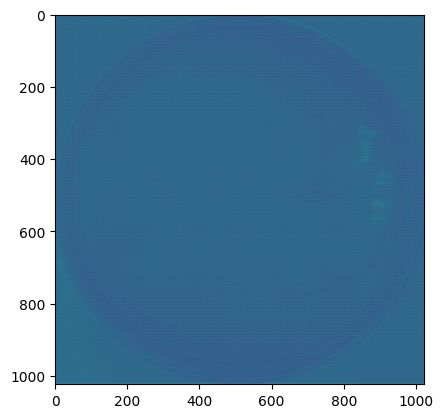

In [21]:
plt.imshow(outputs.cpu().permute(1,2,0).detach().numpy())

In [28]:
test = Test_dataset(val_aug,'crosval/test',device)

['AAE_0223.png', 'AAE_0237.png', 'AAE_0221.png', 'AAE_0023.png', 'AAE_0086.png', 'AAE_0074.png', 'AAE_0138.png', 'AAE_0160.png', 'AAE_0172.png', 'AAE_0205.png']


In [29]:
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [30]:
outputs
for inputs in tqdm(test_loader):
    model.eval()
    outputs = model(inputs)

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 32, 512, 512])
torch.Size([10, 64, 256, 256])
torch.Size([10, 128, 128, 128])
torch.Size([10, 256, 64, 64])
torch.Size([10, 512, 32, 32])
torch.Size([10, 256, 64, 64])
torch.Size([10, 128, 128, 128])
torch.Size([10, 64, 256, 256])


100%|██████████| 1/1 [00:36<00:00, 36.67s/it]


In [31]:
outputs.shape

torch.Size([10, 1, 1024, 1024])

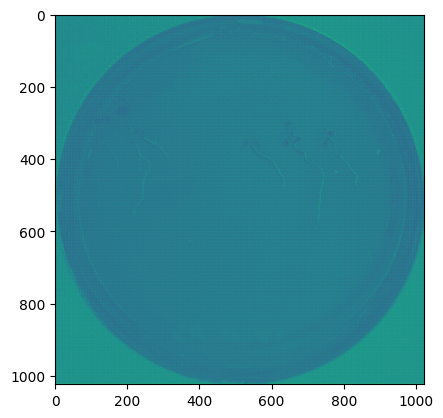

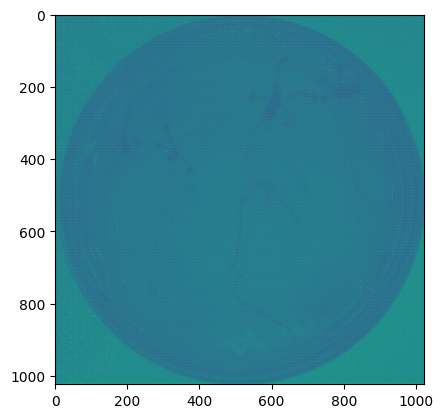

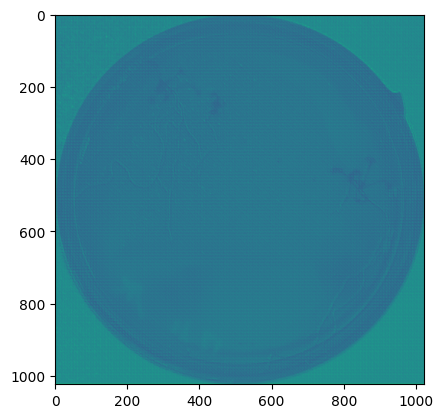

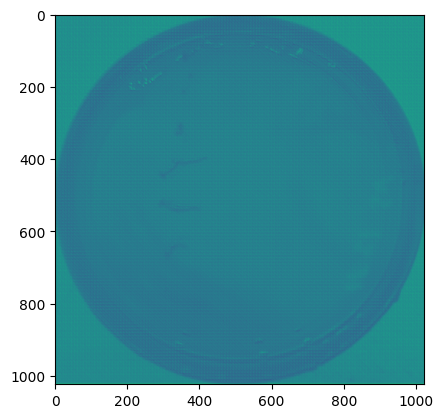

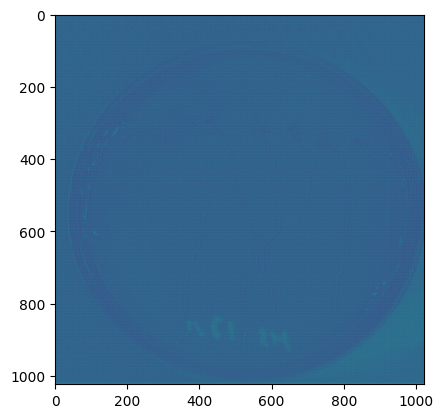

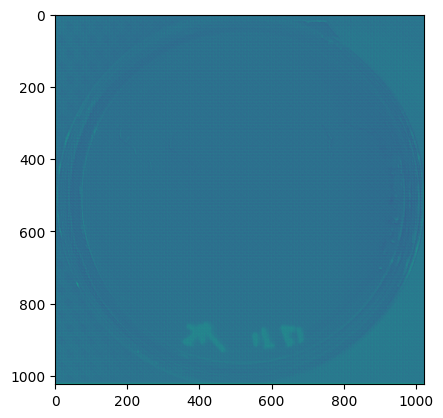

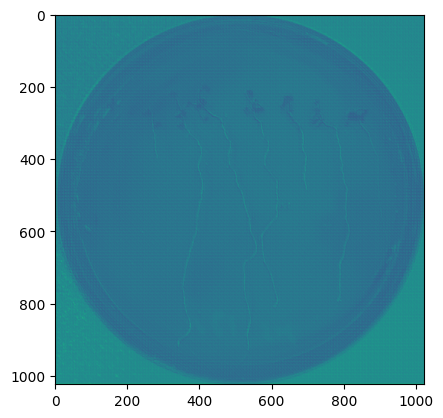

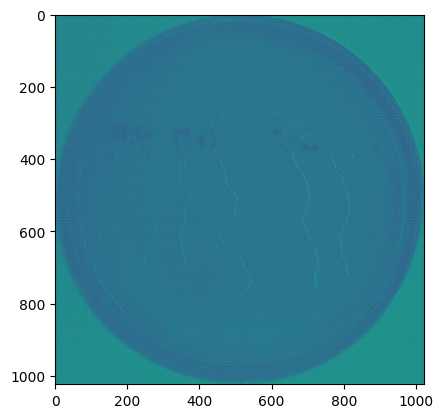

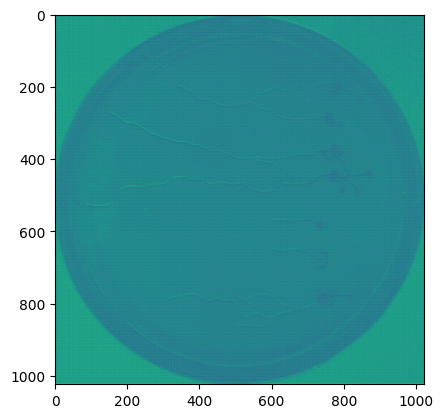

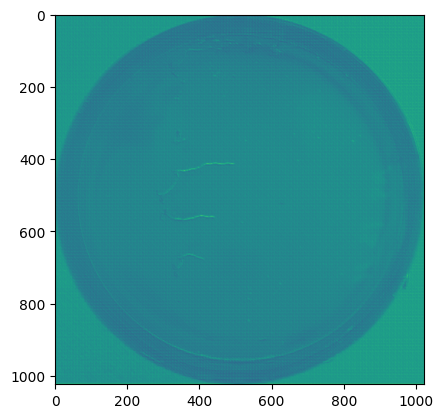

In [32]:
for i in outputs:
    i.reshape(1, height, height)
    plt.imshow(i.cpu().permute(1,2,0).detach().numpy())
    plt.pause(1)